In [1]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract
!pip install easyocr
!pip install opencv-python-headless==4.1.2.30
!pip install Pillow
!pip install ftfy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (11.1 MB

     |████████████████████████████████| 70.8 MB 21 kB/s 
     |████████████████████████████████| 47.6 MB 84 kB/s 
     |████████████████████████████████| 21.8 MB 5.1 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.4.60
    Uninstalling opencv-python-headless-4.5.4.60:
      Successfully uninstalled opencv-python-headless-4.5.4.60
     |████████████████████████████████| 53 kB 57 kB/s 


In [1]:
import json
import pytesseract
import cv2
import numpy as np
import sys
import os
import ftfy
import io
import re
import easyocr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [2]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [3]:
def pan_read_data(text):
  name = None
  fname = None
  dob = None
  pan = None
  text0 = []
  text1 = []
  lines = text.split(',')
  for lin in lines:
    s = lin.strip()
    s = lin.replace('\n','')
    s = s.rstrip()
    s = s.lstrip()
    text1.append(s)
  text1 = list(filter(None, text1))
  lineno = 0
  for wordline in text1:
    xx = wordline.split('\n')
    if ([w for w in xx if re.search('(INCOMETAXDEPARWENT|INCOME|TAX|GOW|GOVT|GOVERNMENT|OVERNMENT|VERNMENT|DEPARTMENT|EPARTMENT|PARTMENT|ARTMENT|INDIA|NDIA)$', w)]):
        text1 = list(text1)
        lineno = text1.index(wordline)
        
  text0 = text1[lineno+1:]
  try:
# Cleaning first names
      name = text0[0]
      name = name.rstrip()
      name = name.lstrip()
      name = name.replace("8", "B")
      name = name.replace("0", "D")
      name = name.replace("6", "G")
      name = name.replace("1", "I")
      name = re.sub('[^a-zA-Z] +', ' ', name)
# Cleaning Father's name
      fname = text0[1]
      fname = fname.rstrip()
      fname = fname.lstrip()
      fname = fname.replace("8", "S")
      fname = fname.replace("0", "O")
      fname = fname.replace("6", "G")
      fname = fname.replace("1", "I")
      fname = fname.replace("\"", "A")
      fname = re.sub('[^a-zA-Z] +', ' ', fname)
# extractin DOB
      dob = re.search(r'\d{2}.\d{2}.\d{4}',text).group()
# Cleaning PAN Card details
      lineno = 0
      for wordline in text1:
        xx = wordline.split('\n')
        if ([w for w in xx if re.search('(Pormanam|Number|umber|Account|ccount|count|Permanent|ermanent|manent|wumm)$', w)]):
            text1 = list(text1)
            lineno = text1.index(wordline)
            
      text0 = text1[lineno+1:]
      pan = text0[0]
      pan = pan.rstrip()
      pan = pan.lstrip()
      pan = pan.replace(" ", "")
      pan = pan.replace("\"", "")
      pan = pan.replace(";", "")
      pan = pan.replace("%", "L")
  except:
          pass
  data = {}
  data['Name'] = name
  data['Father Name'] = fname
  data['Date of Birth'] = dob
  data['PAN'] = pan
  data['ID Type'] = "PAN"
  return data

def findword(textlist, wordstring):
    lineno = -1
    for wordline in textlist:
        xx = wordline.split( )
        if ([w for w in xx if re.search(wordstring, w)]):
            lineno = textlist.index(wordline)
            textlist = textlist[lineno+1:]
            return textlist
    return textlist

In [4]:
def adhaar_read_data(text):
    res=text.split(',')
    name = None
    dob = None
    adh = None
    sex = None
    nameline = []
    dobline = []
    text0 = []
    text1 = []
    text2 = []
    lines = text.split(',')
    for lin in lines:
        s = lin.strip()
        s = lin.replace('\n','')
        s = s.rstrip()
        s = s.lstrip()
        text1.append(s)

    if 'female' in text.lower():
        sex = "FEMALE"
    else:
        sex = "MALE"

    # extractin DOB
    dob = re.search(r'\d{2}.\d{2}.\d{4}',text).group()
    adh = re.search(r'\d{4}\s\d{4}\s\d{4}',text).group()
    
    text1 = list(filter(None, text1))
    text0 = text1[:]
    
    try:

        # Cleaning first names
        name = text0[3]
        name = name.rstrip()
        name = name.lstrip()
        name = name.replace("8", "B")
        name = name.replace("0", "D")
        name = name.replace("6", "G")
        name = name.replace("1", "I")
        name = re.sub('[^a-zA-Z] +', ' ', name)

    except:
        pass

    data = {}
    data['Name'] = name
    data['Date of Birth'] = dob
    data['Adhaar Number'] = adh
    data['Sex'] = sex
    data['ID Type'] = "Adhaar"
    return data


In [5]:
def extractinfo(text):
  data = None
  if "income" in text.lower() or "tax" in text.lower() or "department" in text.lower():
      data = pan_read_data(text)
  
  elif "male" in text.lower():
      data = adhaar_read_data(text)
  return data

def split_text(text):
  text1 = []
  for lin in text.split(','):
    s = lin.strip()
    s = lin.replace('\n','')
    s = s.rstrip()
    s = s.lstrip()
    text1.append(s)
  return text1

In [6]:
def detect_text_blocks(img_path):
    detection_result = reader.detect(img_path,
                                 width_ths=0.7, 
                                 mag_ratio=1.5
                                 )
    text_coordinates = detection_result[0][0]
    return text_coordinates

def draw_bounds(img_path, bbox):
    image = Image.open(img_path)  
    draw = ImageDraw.Draw(image)
    for b in bbox:
        p0, p1, p2, p3 = [b[0], b[2]], [b[1], b[2]], \
                         [b[1], b[3]], [b[0], b[3]]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill='red', width=2)
    return np.asarray(image)

In [19]:
img = cv2.imread("/content/aadhar1.jpg")
img = cv2.resize(img, None, fx=2, fy=2,interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
var = cv2.Laplacian(img, cv2.CV_64F).var()
if var < 50:
    print("Image is Too Blurry....")
    k= input('Press Enter to Exit.')
    exit(1)

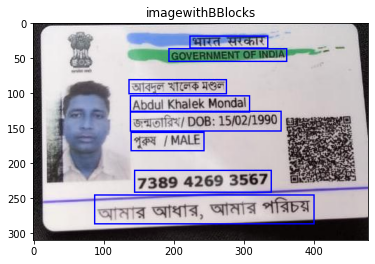

In [20]:
filename = "/content/aadhar1.jpg"
#text = pytesseract.image_to_string(Image.open(filename), lang = 'eng')
text_coordinates = detect_text_blocks(filename)
text_blocks_in_image = draw_bounds(filename, text_coordinates)
plt_imshow("imagewithBBlocks",text_blocks_in_image)
recognition_results = reader.recognize(filename,
                                 horizontal_list=text_coordinates,
                                 free_list=[]
                                 )
detected_text = [txt[1] for txt in recognition_results]
detected_text = ",".join(detected_text)
#

In [21]:
text = detected_text
text

'9TT HTTn,GOVERNMENT OF INDIA,UnGT 3164 487,Abdul Khalek Mondal,54olfav/ DOB: 15/02/1990,444 / MALE,7389 4269 3567,W14m 4i41s, W1413 41f4113'

In [22]:
extractinfo(text)

{'Adhaar Number': '7389 4269 3567',
 'Date of Birth': '15/02/1990',
 'ID Type': 'Adhaar',
 'Name': 'Abdul Khalek Mondal',
 'Sex': 'MALE'}

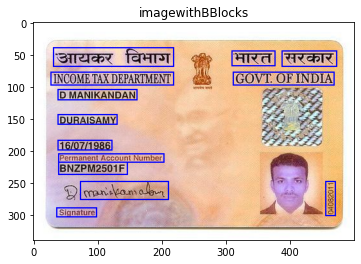

{'Date of Birth': '16/07/1986',
 'Father Name': 'DURAISAMY',
 'ID Type': 'PAN',
 'Name': 'D MANIKANDAN',
 'PAN': 'BNZPM2SOIF'}

In [ ]:
filename = "/content/Pansample1.jpg"
#text = pytesseract.image_to_string(Image.open(filename), lang = 'eng')
text_coordinates = detect_text_blocks(filename)
text_blocks_in_image = draw_bounds(filename, text_coordinates)
plt_imshow("imagewithBBlocks",text_blocks_in_image)
recognition_results = reader.recognize(filename,
                                 horizontal_list=text_coordinates,
                                 free_list=[]
                                 )
detected_text = [txt[1] for txt in recognition_results]
detected_text = ",".join(detected_text)
extractinfo(detected_text)